In [1]:
#IMPORTAR LAS LIBRERÍAS NECESARIAS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from scipy.stats import norm

In [2]:
#DEFINIR EL RANGO DE FECHAS PARA OBTENER LOS DATOS
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365 * years)

In [3]:
#DESCARGAR LOS DATOS DE LOS TICKERS
tickers = ['SPY', 'GLD', 'QQQ']

#DESCARGAR EL VALOR DE CIERRE AJUSTADO DE CADA TICKER POR DIA
adj_close_df = pd.DataFrame()

for i in tickers:
    data = yf.download(i, start = startDate, end = endDate)
    adj_close_df[i] = data['Close']

adj_close_df

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,SPY,GLD,QQQ
Date,,,
2010-09-22,86.807098,126.199997,42.727215
2010-09-23,86.102943,126.300003,42.709682
2010-09-24,87.878601,126.690002,43.578442
2010-09-27,87.457664,126.720001,43.341499
2010-09-28,87.763809,127.849998,43.323936
...,...,...,...
2025-09-11,657.630005,334.760010,584.080017
2025-09-12,657.409973,335.420013,586.659973
2025-09-15,660.909973,338.910004,591.679993


In [4]:
#CALCULAR LOS RETORNOS LOGARITMICOS DE CADA TICKER
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

log_returns

,SPY,GLD,QQQ
Date,,,
2010-09-23,-0.008145,0.000792,-0.000410
2010-09-24,0.020413,0.003083,0.020137
2010-09-27,-0.004801,0.000237,-0.005452
2010-09-28,0.003494,0.008878,-0.000405
2010-09-29,-0.001746,0.000782,-0.001621
...,...,...,...
2025-09-11,0.008276,-0.001492,0.005804
2025-09-12,-0.000335,0.001970,0.004407
2025-09-15,0.005310,0.010351,0.008521


In [5]:
#CREAR UNA FUNCIÓN QUE CALCULE EL VALOR ESPERADO DE RETORNO BASADO EN LOS RETORNOS LOGARITMICOS PARA EL PORTAFOLIO (TICKERS).
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()* weights)

In [6]:
#CREAR UNA FUNCIÓN PARA OBTENER LA DESVIACIÓN ESTÁNDAR DEL PORTAFOLIO
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [7]:
#CREAR MATRIZ DE COVARIANZA
cov_matrix = log_returns.cov()
cov_matrix

,SPY,GLD,QQQ
SPY,0.000117,0.000005,0.000132
GLD,0.000005,0.000097,0.000006
QQQ,0.000132,0.000006,0.000170


In [8]:
#CREAR UN PORTAFOLIO CON PESOS EQUILIBRADOS Y ENCONTRAR EL TOTAL ESPERADO DE RETORNO
portfolio_value = 1000000
weights = np.array([1/len(tickers)] * len(tickers))
portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation(weights, cov_matrix)

In [9]:
#CREAR UNA FUNCIÓN QUE REGRESE UN VALOR ALEATORIO (Z-SCORE) BASADO EN LA DISTRIBUCIÓN NORMAL
def randomz_score():
    return np.random.normal(0,1)

In [10]:
#CREAR FUNCIÓN PARA CALCULAR EL ESCENARIO DE PERDIDA/GANANCIA
days = 5
def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * (portfolio_expected_return * days + z_score * portfolio_std_dev * np.sqrt(days))

In [11]:
#HACER LA SIMULACIÓN
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = randomz_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

In [12]:
#ESPECIFICAR EL INTERVALO DE CONFIANZA Y CALCULAR EL VALOR EN RIESGO
confidence_interval = 0.99
VaR = -np.percentile(scenarioReturn, 100 * (1 - confidence_interval))
VaR

np.float64(41891.36997295168)

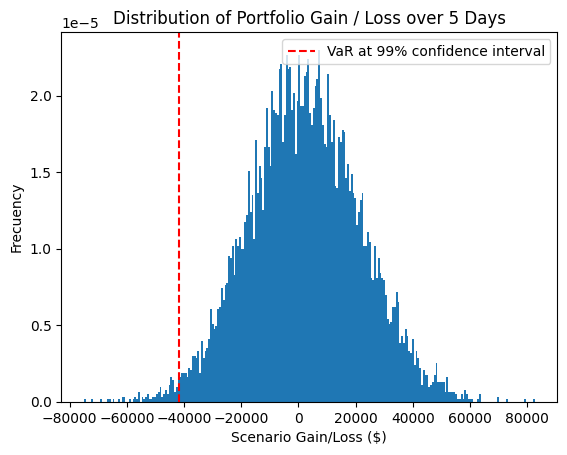

In [13]:
#GRAFICAR RESULTADOS
plt.hist(scenarioReturn, bins = 250, density = True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frecuency')
plt.title(f'Distribution of Portfolio Gain / Loss over {days} Days')
plt.axvline(-VaR, color = 'r', linestyle = 'dashed', label=f'VaR at {confidence_interval:.0%} confidence interval')
plt.legend()
plt.show()